In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
plt.style.use('fivethirtyeight')
import seaborn as sns

In [2]:
credit= pd.read_csv('Data.csv')

In [3]:
#Understanding the features
c= credit.columns
print(c[0],': Customer Id')
print(c[1],': Money the customer owe to the credit card company')
print(c[2],': Ratio of last 12 month with balance ')
print(c[3],': total  purchase amount spent during last 12 month')
print(c[4],': total amount paid without any continuous history of payments or ontime payments')
print(c[5],': total amount paid using installments')
print(c[6],': total money taken out using ATM,etc')
print(c[7],': percent of month with atleast one purchase')
print(c[8],': percent of month with atleast one oneoff purchase')
print(c[9],': percent of month with atleast one purchase using installments')
print(c[10],': percent of month with atleast one cash_advance')
print(c[11],': average amount used during a cash advance transaction')
print(c[12],': average amout used during a purchase')
print(c[13],': credit limit on the card')
print(c[14],': Due ammount paid by the customer to decrease their statement balance')
print(c[15],': Total minimum payment amount paid')
print(c[16],': Percentage of months with full payment of the due statement balance')
print(c[17],': Tenure')

CUST_ID : Customer Id
BALANCE : Money the customer owe to the credit card company
BALANCE_FREQUENCY : Ratio of last 12 month with balance 
PURCHASES : total  purchase amount spent during last 12 month
ONEOFF_PURCHASES : total amount paid without any continuous history of payments or ontime payments
INSTALLMENTS_PURCHASES : total amount paid using installments
CASH_ADVANCE : total money taken out using ATM,etc
PURCHASES_FREQUENCY : percent of month with atleast one purchase
ONEOFF_PURCHASES_FREQUENCY : percent of month with atleast one oneoff purchase
PURCHASES_INSTALLMENTS_FREQUENCY : percent of month with atleast one purchase using installments
CASH_ADVANCE_FREQUENCY : percent of month with atleast one cash_advance
CASH_ADVANCE_TRX : average amount used during a cash advance transaction
PURCHASES_TRX : average amout used during a purchase
CREDIT_LIMIT : credit limit on the card
PAYMENTS : Due ammount paid by the customer to decrease their statement balance
MINIMUM_PAYMENTS : Total min

In [4]:
#found some missing values in the dataset
na_values= credit.isna().sum()
na_values[na_values>0]

CREDIT_LIMIT          1
MINIMUM_PAYMENTS    313
dtype: int64

In [5]:
#Filling missing values with median

credit['CREDIT_LIMIT']= credit['CREDIT_LIMIT'].fillna(credit['CREDIT_LIMIT'].median())
credit['MINIMUM_PAYMENTS']= credit['MINIMUM_PAYMENTS'].fillna(credit['MINIMUM_PAYMENTS'].median())

## Deriving a new KPI( Key performance index)

1. Monthly average purchase and cash advance amount

In [6]:
credit['MONTHLY_AVG_PURCHASE']=credit['PURCHASES']/credit['TENURE']
credit['MONTHLY_CASH_ADVANCE']=credit['CASH_ADVANCE']/credit['TENURE']

In [7]:
credit[['MONTHLY_AVG_PURCHASE','MONTHLY_CASH_ADVANCE']]

MONTHLY_AVG_PURCHASE  MONTHLY_CASH_ADVANCE
0                 7.950000              0.000000
1                 0.000000            536.912124
2                64.430833              0.000000
3               124.916667             17.149001
4                 1.333333              0.000000
...                    ...                   ...
8945             48.520000              0.000000
8946             50.000000              0.000000
8947             24.066667              0.000000
8948              0.000000              6.093130
8949            182.208333             21.173335

[8950 rows x 2 columns]

2- Purchases by type (one-off, installments) <br>
   -To find what type of purchases customers are making on credit card



In [8]:
o_p= 'ONEOFF_PURCHASES'
i_p= 'INSTALLMENTS_PURCHASES'
print('\033[1mPurchase on \033[0m :')
print('\t Only oneoff  :',credit[(credit[o_p]>0) & (credit[i_p]==0)].shape[0])
print('\t only  installments :',credit[(credit[o_p]==0) & (credit[i_p]>0)].shape[0])
print('\t installments and oneoff :',credit[(credit[o_p]>0) & (credit[i_p]>0)].shape[0])
print('\t None :',credit[(credit[o_p]==0) & (credit[i_p]==0)].shape[0])

Purchase on  :
	 Only oneoff  : 1874
	 only  installments : 2260
	 installments and oneoff : 2774
	 None : 2042


As per above detail we found out that there are 4 types of purchase behaviour in the data set. So we need to derive a categorical variable based on their behaviour

In [9]:
def purchase_type(credit):
    if (credit['ONEOFF_PURCHASES']==0) & (credit['INSTALLMENTS_PURCHASES']==0):
        return 'none'
    if (credit['ONEOFF_PURCHASES']>0) & (credit['INSTALLMENTS_PURCHASES']>0):
         return 'both_oneoff_installment'
    if (credit['ONEOFF_PURCHASES']>0) & (credit['INSTALLMENTS_PURCHASES']==0):
        return 'one_off'
    if (credit['ONEOFF_PURCHASES']==0) & (credit['INSTALLMENTS_PURCHASES']>0):
        return 'istallment'
credit['PURCHASE_TYPE']=credit.apply(purchase_type,axis=1)

Text(0.5, 1.0, 'Purchase % by type')

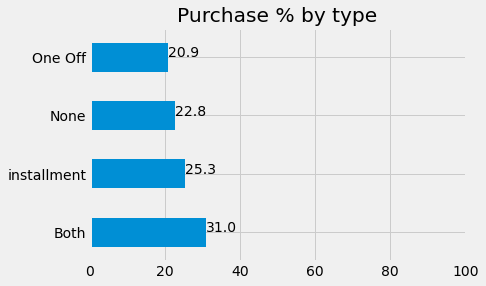

In [10]:
vc_Ptype= credit['PURCHASE_TYPE'].value_counts()
vc_Ptype= vc_Ptype/np.sum(vc_Ptype) *100
vc_Ptype.plot(kind='barh')

for i,val in enumerate(vc_Ptype.values):
    plt.annotate(s=str(np.round(val,1)),xy=(val,i))

plt.xlim(0,100)
plt.yticks([0,1,2,3],['Both','installment','None','One Off'])
plt.title('Purchase % by type')

3- What is the Average amount per purchase and cash advance per transaction?

In [11]:
print('The average amount per purchase is :\033[1m',credit['PURCHASES'].mean(),'\033[0m')
print('The Average cash advance per transaction is \033[1m:', credit['CASH_ADVANCE'].mean(),'\033[0m')

The average amount per purchase is : 1003.2048335195564 
The Average cash advance per transaction is : 978.8711124654749 


4. Limit_usage (balance to credit limit ratio ) credit card utilization <br>
    Lower value implies cutomers are maintaing thier balance properly. Lower value means good credit score

Note: Credit Card Utilization ratio is the comparision of total credit used to total credit available

In [12]:
#higher number means high debt or credit card utilization
credit['LIMIT_USAGE']=credit.apply(lambda x: (x['BALANCE']/x['CREDIT_LIMIT']), axis=1)
low,medium,high= credit['LIMIT_USAGE'].describe(percentiles=[0.35,0.6,1.0])[['35%','60%','100%']].values

Text(0.5, 1.0, 'Credit Card Utilization of customers')

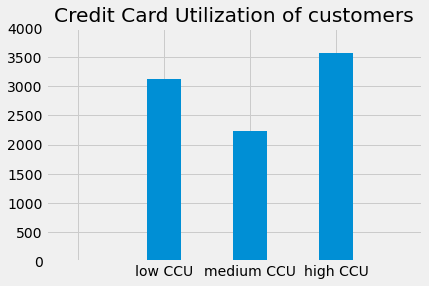

In [13]:
low_count= len(credit[credit['LIMIT_USAGE']<low])
med_count= len(credit[(credit['LIMIT_USAGE']>=low) & (credit['LIMIT_USAGE']<=medium)])
high_count= len(credit[credit['LIMIT_USAGE']>medium])

plt.bar(x=[0,1,0,2,0,3],height= [0,low_count,0,med_count,0,high_count],width=0.4)
plt.xticks([0,1,2,3,4],['','low CCU','medium CCU','high CCU',''])
plt.ylim(0,4000)
plt.title('Credit Card Utilization of customers')

In the above graph we can see that most customers have high Credit Card Utilization value, which means most customers are using using money till their credit limit

5- Payments to minimum payments ratio etc.

In [14]:
#Found no missing values

display(credit['PAYMENTS'].isna().sum())
display(credit['MINIMUM_PAYMENTS'].isna().sum())

0

0

In [15]:
credit['PAYMENT_MINPAY']=credit.apply(lambda x:x['PAYMENTS']/x['MINIMUM_PAYMENTS'],axis=1)

Some other KPI's

Just out of curiosity, I would like to see how much Credit Limit does a person gets on average

In [16]:
print('Average credit the company gives to its customer is : \033[1m',(credit['CREDIT_LIMIT']/credit['TENURE']).mean())

Average credit the company gives to its customer is :  390.78307415737964


How many people have exhausted this limit in the current period

In [17]:
per= len(credit[(credit['BALANCE']- 390.783)>0])/len(credit) *100
print('\033[1m {}% \033[0m  customers have exhausted their credit limit on the current period'.format(np.round(per,2)))

 62.58%   customers have exhausted their credit limit on the current period


## Insight from  KPI

## What is the average minimum payment ratio of each purchase type?

In [18]:
types= credit.groupby('PURCHASE_TYPE').groups.keys()
min_pay=[]
for group in types:
    min_pay.append(credit.groupby('PURCHASE_TYPE').get_group(group)['PAYMENT_MINPAY'].mean())
    

Text(0.5, 1.0, 'Minimum payment comparision of diff purchase type')

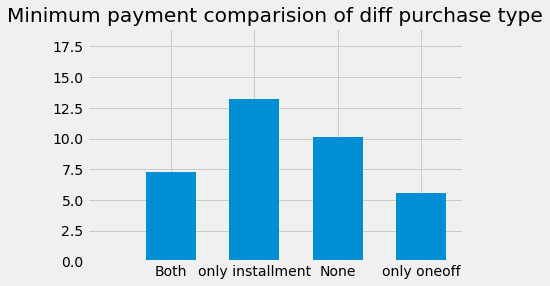

In [19]:
plt.bar(x=['Both','only installment','None','only oneoff'],height= min_pay,width=0.6)
plt.ylim(0,19)
plt.xlim(-1,3.5)
plt.title('Minimum payment comparision of diff purchase type')

## Okay, From the above figure it can be said that customes buying stuffs through installment are more like to pay a minimum payment. So, for the company it is more feasible to make customer buy stuff on installments.

<br>
<br>
<br>

## Cash advance are good for the company, since the company can put tax for the service. So, In the following experiment, let's find average cash advance ratio with respect to purchase type

In [20]:
types

dict_keys(['both_oneoff_installment', 'istallment', 'none', 'one_off'])

Text(0.5, 1.0, 'Average cash advance taken by customers of different Purchase type ')

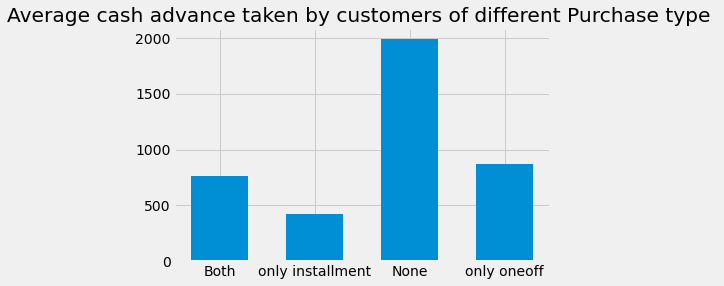

In [21]:
cash_adv=[]
for group in types:
    cash_adv.append(credit.groupby('PURCHASE_TYPE').get_group(group)['CASH_ADVANCE'].mean())
plt.bar(x=['Both','only installment','None','only oneoff'],height= cash_adv,width=0.6)
plt.title('Average cash advance taken by customers of different Purchase type ')

## Customer who do not do any kind of purchase i.e oneoff or in installements tend to take out cash through various means like atm, cheque,etc.

Now the next question which comes after consuming above graph is Does those custome take out money to their credit limit?

Text(0.5, 1.0, 'Credit Limit Usage according to different purchase type')

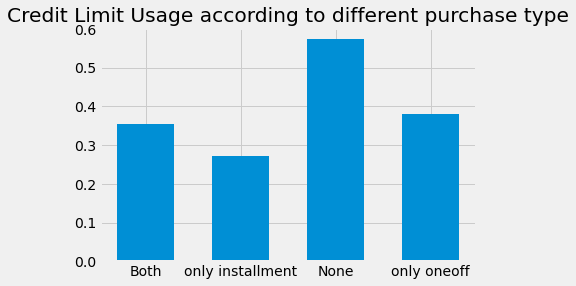

In [22]:
credit_limit=[]
for group in types:
    credit_limit.append(credit.groupby('PURCHASE_TYPE').get_group(group)['LIMIT_USAGE'].mean())
plt.bar(x=['Both','only installment','None','only oneoff'],height= credit_limit,width=0.6)
plt.title('Credit Limit Usage according to different purchase type')

## Customers who don't do either of purchase i.e Oneoff or through installment tends to take more Cash Advance and exhaust their credit limit more frequently

##  Preparing data for machine learning algorithm

In [23]:
dummy_ptype= pd.get_dummies(credit['PURCHASE_TYPE'])

In [24]:
credit_pro= pd.concat([credit,dummy_ptype],axis=1).drop('PURCHASE_TYPE',axis=1)

In [25]:
#well this didnt turned out as expected
cmap = cmap=sns.diverging_palette(5, 200, as_cmap=True)
credit_pro.corr().style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '10px', 'font-size': '10pt'})

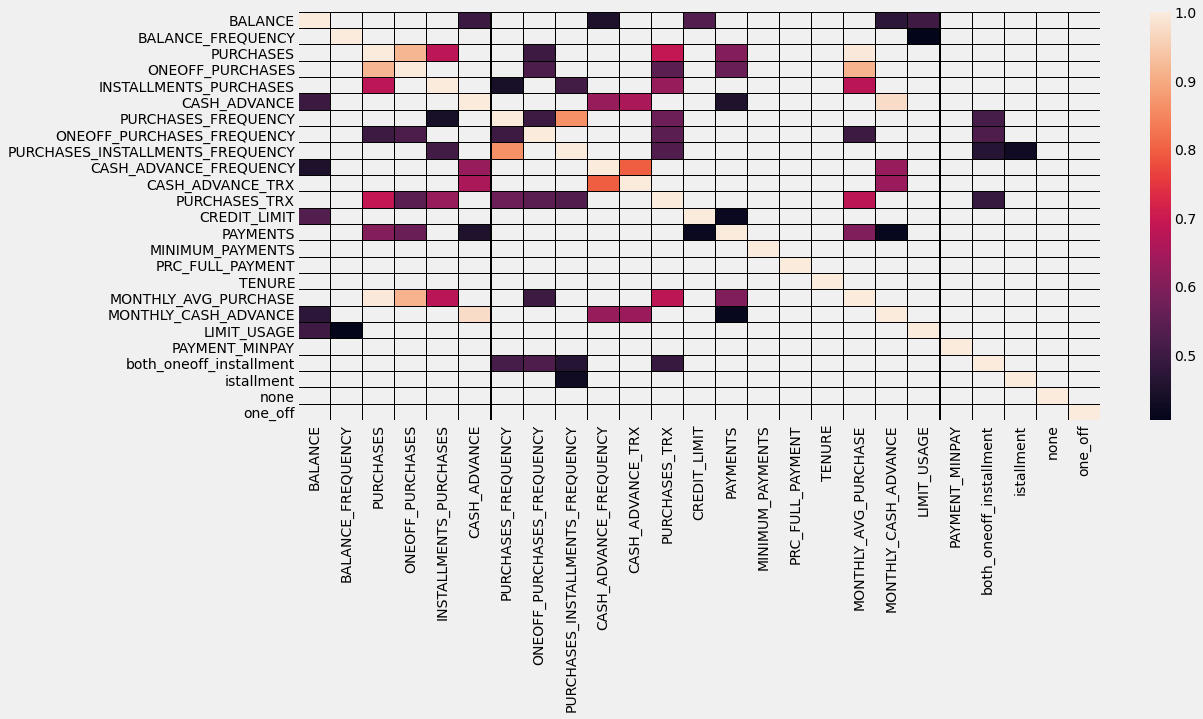

In [26]:
plt.figure(figsize=(16,7))
sns.heatmap(credit_pro.corr()[credit_pro.corr()>0.4],linewidths=0.1,linecolor='black')

- Heat map shows that many features are co-related so applying dimensionality reduction will help negating multi-colinearity in data

    Before applying PCA we will standardize data to avoid effect of scale on our result. Centering and Scaling will make all features with equal weight.


In [27]:
from sklearn.preprocessing import StandardScaler
sc= StandardScaler()

In [28]:
#columns which required normalization
col= ['PURCHASES','CASH_ADVANCE','CREDIT_LIMIT','PAYMENTS','MINIMUM_PAYMENTS','PRC_FULL_PAYMENT','LIMIT_USAGE','BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'MONTHLY_AVG_PURCHASE',
       'MONTHLY_CASH_ADVANCE', 'LIMIT_USAGE', 'PAYMENT_MINPAY',
       'both_oneoff_installment', 'istallment', 'none', 'one_off']

print('Removing Columns which cannot be considered a behavioural atribute: ')

for c in credit_pro.columns:
    if c not in  col:
        print('\t \t \t \t \t \t \t \t  ',c)

print('Scalling the following columns :')     
credit_pro= credit_pro[col].copy()
scaled_credit= sc.fit_transform(credit_pro)
print('\n',col)


Removing Columns which cannot be considered a behavioural atribute: 
	 	 	 	 	 	 	 	   CUST_ID
	 	 	 	 	 	 	 	   BALANCE
	 	 	 	 	 	 	 	   TENURE
Scalling the following columns :

 ['PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS', 'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'LIMIT_USAGE', 'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES', 'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY', 'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY', 'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'MONTHLY_AVG_PURCHASE', 'MONTHLY_CASH_ADVANCE', 'LIMIT_USAGE', 'PAYMENT_MINPAY', 'both_oneoff_installment', 'istallment', 'none', 'one_off']


In [29]:
scaled_credit.shape

(8950, 24)

##  Implementing Principal component analysis which basically reduces data into lower dimensions or into lower features 
it uses the concept of  eigen vector and eigen values( Vectors which do not change their behavious while a linear transformation is applied)

In [30]:
from sklearn.decomposition import PCA
pca=PCA(n_components= 23)
credit_pca= pca.fit(scaled_credit)

In [31]:
#it seem PCA can explain 100% variance
np.sum(credit_pca.explained_variance_ratio_)

1.0000000000000002

our dataset contain features which contain outliers, first i will find how much components are required to explained 95% variance along with features contain outlier and then i will try to find variance without those columns and then we will compare the results

## With Outlier columns

In [32]:
#now let's find least number of dimension from which PCA could explained maximum variance
var_ratio={}
for n in range(2,23):
    pca=PCA(n_components=n)
    cr_pca=pca.fit(scaled_credit)
    var_ratio[n]=sum(cr_pca.explained_variance_ratio_)
var_ratio

{2: 0.4336865158639194,
 3: 0.52809295407261,
 4: 0.6163165123148876,
 5: 0.6784867284436866,
 6: 0.7299334197457118,
 7: 0.771522647657706,
 8: 0.8094620670029176,
 9: 0.8418840386747712,
 10: 0.8705220380926809,
 11: 0.8968148074979949,
 12: 0.9203046054147638,
 13: 0.9401983543975566,
 14: 0.9581270673398954,
 15: 0.970570053585222,
 16: 0.9809441097261299,
 17: 0.9900037365859643,
 18: 0.9973849992488821,
 19: 0.9989098370158079,
 20: 0.9997919260993454,
 21: 0.999999515585834,
 22: 1.0}

Text(0, 0.5, 'Variance explained')

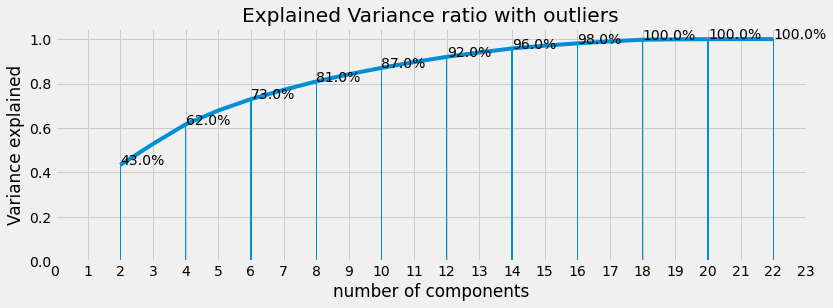

In [33]:
plt.figure(figsize=(12,4))
x= list(var_ratio.keys())
y= list(var_ratio.values())
plt.plot(x,y)
x= np.arange(2,23,step=2)
y= [var_ratio[n] for n in x]
plt.bar(x,y,width=0.04)
for i in x:
    plt.annotate(s=(str(np.round(var_ratio[i],2)*100)+'%'),xy=(i,var_ratio[i]))
plt.xticks(np.arange(0,24))
plt.title('Explained Variance ratio with outliers')
plt.xlabel('number of components')
plt.ylabel('Variance explained')

## it is requiring 14 components are explaining 95% of variance, let's choose 14 features

In [34]:
#number of components which can explained atleast 95% of variance
pca=PCA(n_components=0.95)
cr_pca=pca.fit(scaled_credit)
sum(cr_pca.explained_variance_ratio_)

0.9581270673398957

In [35]:
#Their are some columns in the dataset which contain large value
outlier_col= ['CUST_ID',
 'BALANCE',
 'PURCHASES',
 'CASH_ADVANCE',
 'CREDIT_LIMIT',
 'PAYMENTS',
 'MINIMUM_PAYMENTS',
 'PRC_FULL_PAYMENT',
 'TENURE',
]

col= ['BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'MONTHLY_AVG_PURCHASE',
       'MONTHLY_CASH_ADVANCE', 'LIMIT_USAGE', 'PAYMENT_MINPAY',
       'both_oneoff_installment', 'istallment', 'none', 'one_off']

a= sc.fit_transform(credit_pro[col])

var_ratio={}
for n in range(2,17):
    pca=PCA(n_components=n)
    cr_pca=pca.fit(a)
    var_ratio[n]=sum(cr_pca.explained_variance_ratio_)
var_ratio

{2: 0.4561065759045526,
 3: 0.5706592500886172,
 4: 0.6593783053760636,
 5: 0.7290250185425842,
 6: 0.7925084094482255,
 7: 0.8473258235396088,
 8: 0.8834310763571116,
 9: 0.9153180380509789,
 10: 0.9384161381228784,
 11: 0.961282016524556,
 12: 0.9754694913150209,
 13: 0.9875885411874811,
 14: 0.9976985314066714,
 15: 0.99975203077249,
 16: 1.0}

Text(0, 0.5, 'Variance explained')

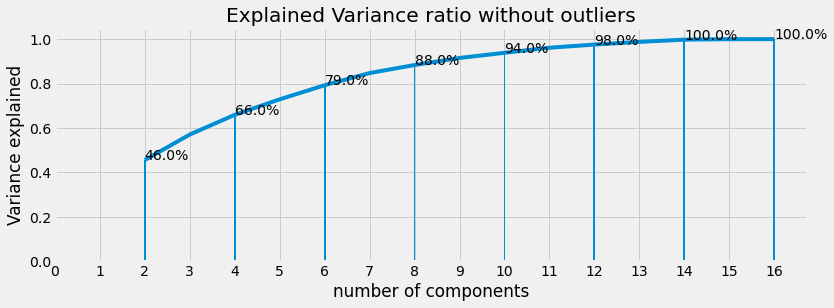

In [36]:
plt.figure(figsize=(12,4))
x= list(var_ratio.keys())
y= list(var_ratio.values())
plt.plot(x,y)
x= np.arange(2,17,step=2)
y= [var_ratio[n] for n in x]
plt.bar(x,y,width=0.04)
for i in x:
    plt.annotate(s=(str(np.round(var_ratio[i],2)*100)+'%'),xy=(i,var_ratio[i]))
plt.xticks(np.arange(0,17))
plt.title('Explained Variance ratio without outliers')
plt.xlabel('number of components')
plt.ylabel('Variance explained')

## 11 Components which can explained 95 % variance without outlier

In [37]:
pca=PCA(n_components=0.95)
cr_pca=pca.fit(a)
sum(cr_pca.explained_variance_ratio_)
print(len(pca.components_))

11


## 90% variance explained should be enough for this problem 

In [38]:
pca_final= PCA(n_components=0.9)
pca_final.fit(scaled_credit)
reduced_credit= pca_final.fit_transform(scaled_credit)

In [39]:
#chose 12 components
print(scaled_credit.shape)
print(reduced_credit.shape)

(8950, 24)
(8950, 12)


In [40]:
dd= pd.DataFrame(pca_final.components_)
dd.columns= credit_pro.columns
dd.T

0         1         2         3  \
PURCHASES                         0.344342  0.153398 -0.084532 -0.117681   
CASH_ADVANCE                     -0.096308  0.366162 -0.120154  0.302823   
CREDIT_LIMIT                      0.142200  0.192900 -0.209249  0.098376   
PAYMENTS                          0.178895  0.286120 -0.189121  0.099868   
MINIMUM_PAYMENTS                  0.010797  0.146556  0.209831 -0.031241   
PRC_FULL_PAYMENT                  0.144303 -0.140796 -0.169758  0.202038   
LIMIT_USAGE                      -0.110102  0.255135  0.423442 -0.239706   
BALANCE_FREQUENCY                 0.058512  0.168676  0.340168 -0.091717   
ONEOFF_PURCHASES                  0.289083  0.159495 -0.166252 -0.209972   
INSTALLMENTS_PURCHASES            0.283024  0.069594  0.105518  0.107528   
PURCHASES_FREQUENCY               0.304447 -0.097866  0.220270  0.182999   
ONEOFF_PURCHASES_FREQUENCY        0.255739  0.077770 -0.096138 -0.236520   
PURCHASES_INSTALLMENTS_FREQUENCY  0.260501 -0.101921  0.310317  0.324949   
CASH_ADVANCE_FREQUENCY           -0.145830  0.346070 -0.000313  0.148954   
CASH_ADVANCE_TRX                 -0.105282  0.332915 -0.034983  0.225646   
PURCHASES_TRX                     0.324927  0.091128  0.089460 -0.008254   
MONTHLY_AVG_PURCHASE              0.343195  0.153690 -0.085597 -0.116172   
MONTHLY_CASH_ADVANCE             -0.098764  0.359041 -0.120072  0.300110   
LIMIT_USAGE                      -0.110102  0.255135  0.423442 -0.239706   
PAYMENT_MINPAY                    0.010267 -0.014929 -0.062012  0.047415   
both_oneoff_installment           0.249569  0.061097  0.115488 -0.014954   
istallment                        0.007316 -0.215544  0.179430  0.387444   
none                             -0.223868  0.158830 -0.044863 -0.037373   
one_off                          -0.060591 -0.003106 -0.276593 -0.358168   

                                         4         5         6         7  \
PURCHASES                         0.251116 -0.005458 -0.039679 -0.105866   
CASH_ADVANCE                     -0.092254  0.115469  0.009490  0.021303   
CREDIT_LIMIT                     -0.081163  0.029194  0.003219  0.450915   
PAYMENTS                          0.204264  0.066447 -0.009720 -0.035122   
MINIMUM_PAYMENTS                  0.198076  0.267146  0.075077  0.683101   
PRC_FULL_PAYMENT                  0.018920 -0.014044 -0.153853 -0.215957   
LIMIT_USAGE                       0.092611  0.089871  0.043566 -0.106847   
BALANCE_FREQUENCY                -0.203424 -0.000318 -0.121972 -0.191808   
ONEOFF_PURCHASES                  0.194590  0.017667 -0.048427 -0.177420   
INSTALLMENTS_PURCHASES            0.236365 -0.045210 -0.004894  0.075465   
PURCHASES_FREQUENCY              -0.253913  0.155169  0.039530 -0.064262   
ONEOFF_PURCHASES_FREQUENCY       -0.392979  0.030835  0.042752 -0.028804   
PURCHASES_INSTALLMENTS_FREQUENCY -0.071674  0.010990  0.028978 -0.015923   
CASH_ADVANCE_FREQUENCY           -0.126555 -0.027848 -0.011224 -0.193625   
CASH_ADVANCE_TRX                 -0.154643  0.045804 -0.004451 -0.189807   
PURCHASES_TRX                    -0.005418 -0.040784  0.028189 -0.006464   
MONTHLY_AVG_PURCHASE              0.246622  0.000279 -0.039516 -0.109829   
MONTHLY_CASH_ADVANCE             -0.092528  0.110330  0.008315  0.012148   
LIMIT_USAGE                       0.092611  0.089871  0.043566 -0.106847   
PAYMENT_MINPAY                    0.088676 -0.057698  0.962665 -0.138125   
both_oneoff_installment          -0.388676 -0.367127  0.073540  0.189747   
istallment                        0.299999  0.350943 -0.044417 -0.150746   
none                              0.279490 -0.512180 -0.073505  0.013726   
one_off                          -0.166813  0.570821  0.039651 -0.068867   

                                         8         9        10        11  
PURCHASES                        -0.067109 -0.003321 -0.058550  0.078849  
CASH_ADVANCE                     -0.023238 -0.049329  0.274855 -0.109525  
CREDIT_LIMIT  

So above data gave us eigen vector for each component we had all eigen vector value very small we can remove those variable bur in our case its not.
## We have succefully reduced the dataset into 12 dimension/ features which can explained about 90% of the variance

## Clustering

Based on the intuition on type of purchases made by customers and their distinctive behavior exhibited based on the purchase_type (as visualized above in Insights from KPI) , I am starting with 4 clusters.


In [41]:
from sklearn.cluster import KMeans
km_4=KMeans(n_clusters=4,random_state=123)

In [42]:
km_4.fit(reduced_credit)

KMeans(n_clusters=4, random_state=123)

In [43]:
km_4.labels_

array([0, 1, 2, ..., 0, 1, 2])

In [44]:
pd.Series(km_4.labels_).value_counts()

0    3594
1    2508
2    1683
3    1165
dtype: int64

## Here we didn't knew k value so we will find the K. To do that we need to take a cluster range between 1 and 21.


In [45]:
cluster_range = range( 1, 21 )
cluster_errors = []

for num_clusters in cluster_range:
    clusters = KMeans( num_clusters )
    clusters.fit( reduced_credit )
    cluster_errors.append( clusters.inertia_ )# clusters.inertia_ is basically cluster error here.

In [46]:
clusters_df = pd.DataFrame( { "num_clusters":cluster_range, "cluster_errors": cluster_errors } )
clusters_df[0:21]

num_clusters  cluster_errors
0              1   197681.429243
1              2   164333.009113
2              3   142782.948209
3              4   128841.126535
4              5   114142.326528
5              6   102610.993849
6              7    95020.779018
7              8    89946.804434
8              9    83134.934439
9             10    79425.664697
10            11    74962.808652
11            12    72188.292200
12            13    68391.143854
13            14    65125.786265
14            15    63242.780785
15            16    61114.688969
16            17    59016.108163
17            18    56747.551234
18            19    55196.012102
19            20    53579.750123

Text(0.5, 1.0, 'Cluster errors with respect to number of cluster')

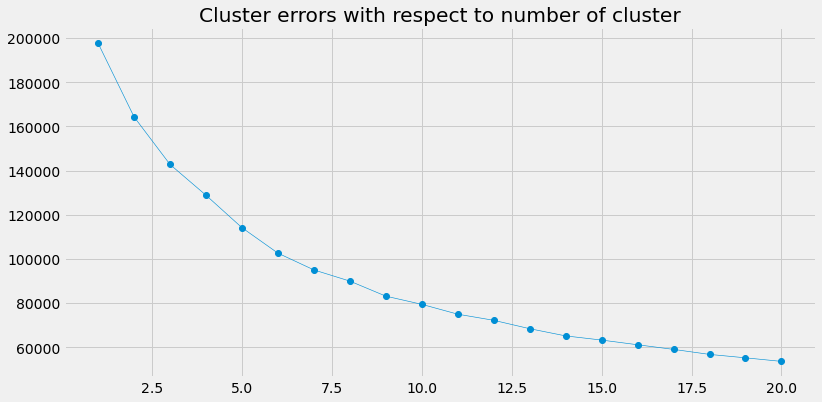

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.plot( clusters_df.num_clusters, clusters_df.cluster_errors, marker = "o",linewidth=0.6)
plt.title('Cluster errors with respect to number of cluster')

## From above graph we will find elbow range. here it is 4,5,6

In [48]:
from sklearn import metrics
# calculate SC for K=3 through K=12
k_range = range(2, 21)
scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=1)
    km.fit(reduced_credit)
    scores.append(metrics.silhouette_score(reduced_credit, km.labels_))

In [49]:
scores

[0.20809560778630934,
 0.2082573512977222,
 0.2243757454520259,
 0.26813469669131024,
 0.2870041512367154,
 0.2847342984702304,
 0.28548577348109944,
 0.28743127297783416,
 0.2797118777856617,
 0.2751485970133593,
 0.266295791465607,
 0.2702146921707467,
 0.26351530059068684,
 0.26016558530411876,
 0.24710898126900568,
 0.2572226720341776,
 0.25261199137274837,
 0.2542649916586567,
 0.2539449749871949]

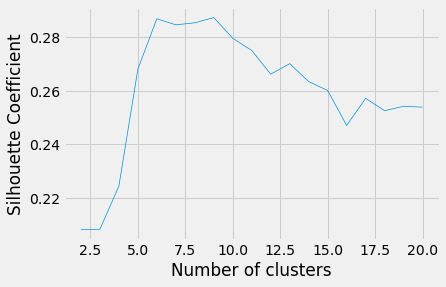

In [50]:
plt.plot(k_range, scores,linewidth=0.7)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')
plt.grid(True)

## Choosing k=4 i.e 0,1,2,3

No handles with labels found to put in legend.


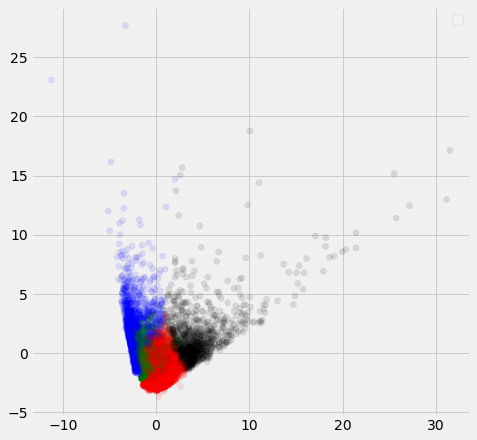

In [51]:
color_map={0:'r',1:'b',2:'g',3:'black'}
label_color=[color_map[l] for l in km_4.labels_]
plt.figure(figsize=(7,7))
plt.scatter(reduced_credit[:,0],reduced_credit[:,1],c=label_color,cmap='Spectral',alpha=0.1)
plt.legend()


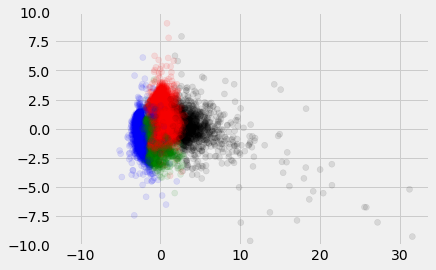

In [52]:
plt.ylim(-10,10)
plt.scatter(reduced_credit[:,0],reduced_credit[:,2],c=label_color,cmap='Spectral',alpha=0.1)

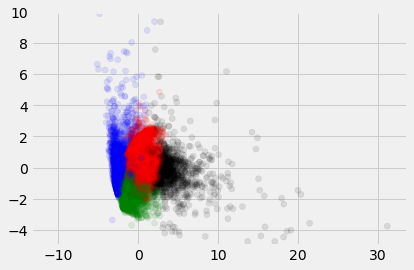

In [53]:
plt.ylim(-5,10)
display(plt.scatter(reduced_credit[:,0],reduced_credit[:,3],c=label_color,cmap='Spectral',alpha=0.1))

It is very difficult to draw iddividual plot for cluster, so we will use pair plot which will provide us all graph in one shot. To do that we need to take following steps

In [54]:
df_pair_plot=pd.DataFrame(reduced_credit,columns=['PC_' +str(i) for i in range(12)])
df_pair_plot['Cluster']=km_4.labels_

In [55]:
df_pair_plot

PC_0      PC_1      PC_2      PC_3      PC_4      PC_5      PC_6  \
0    -1.158157 -2.190153 -0.266116  0.522572  0.894398  0.312218 -0.196724   
1    -2.413587  2.734066 -1.287587  1.371446  0.511100 -0.696263 -0.283675   
2     0.725273 -0.494050 -0.857060 -2.162518 -1.906947  1.577806  0.174579   
3    -0.703056 -0.600457 -2.011541 -1.610284  0.231709  1.068589  0.035303   
4    -1.714998 -0.626736  0.112569 -2.263541 -0.101946  1.207402  0.064816   
...        ...       ...       ...       ...       ...       ...       ...   
8945  0.494097 -2.628963  0.712050  1.798647  0.235922  0.598298 -0.389262   
8946  0.257341 -2.385515  1.011981  1.456769  0.219066  0.649399 -0.167284   
8947 -0.047776 -2.618217  0.403780  1.480037  0.388510  0.549446 -0.238234   
8948 -2.027329 -1.052637 -1.092244 -0.231498  0.778182 -1.814063 -0.449781   
8949  0.018174 -0.259095 -1.200970 -1.848577 -0.964292  1.250613  0.190263   

          PC_7      PC_8      PC_9     PC_10     PC_11  Cluster  
0    -0.197441 -0.610976 -0.410069 -0.101439  0.676886        0  
1     0.460978  0.901253 -0.560978  1.283371 -0.579462        1  
2     0.229079  0.682672 -0.758547 -0.263225  0.191809        2  
3     0.483072 -0.630484 -0.511299 -0.503446 -0.030418        2  
4    -0.462705 -0.035900 -0.264032  0.136072 -0.826165        2  
...        ...       ...       ...       ...       ...      ...  
8945 -0.923734  0.752036 -0.023145  0.007478  0.461256        0  
8946 -0.465542 -0.390270 -0.715445 -0.246733  0.872869        0  
8947 -0.538458 -0.128370 -0.094999  0.049939  0.647087        0  
8948 -0.275027  0.457585  0.515040 -0.603483  0.184652        1  
8949 -0.834989 -0.889445  0.893642 -0.730469  0.165907        2  

[8950 rows x 13 columns]

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1912: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


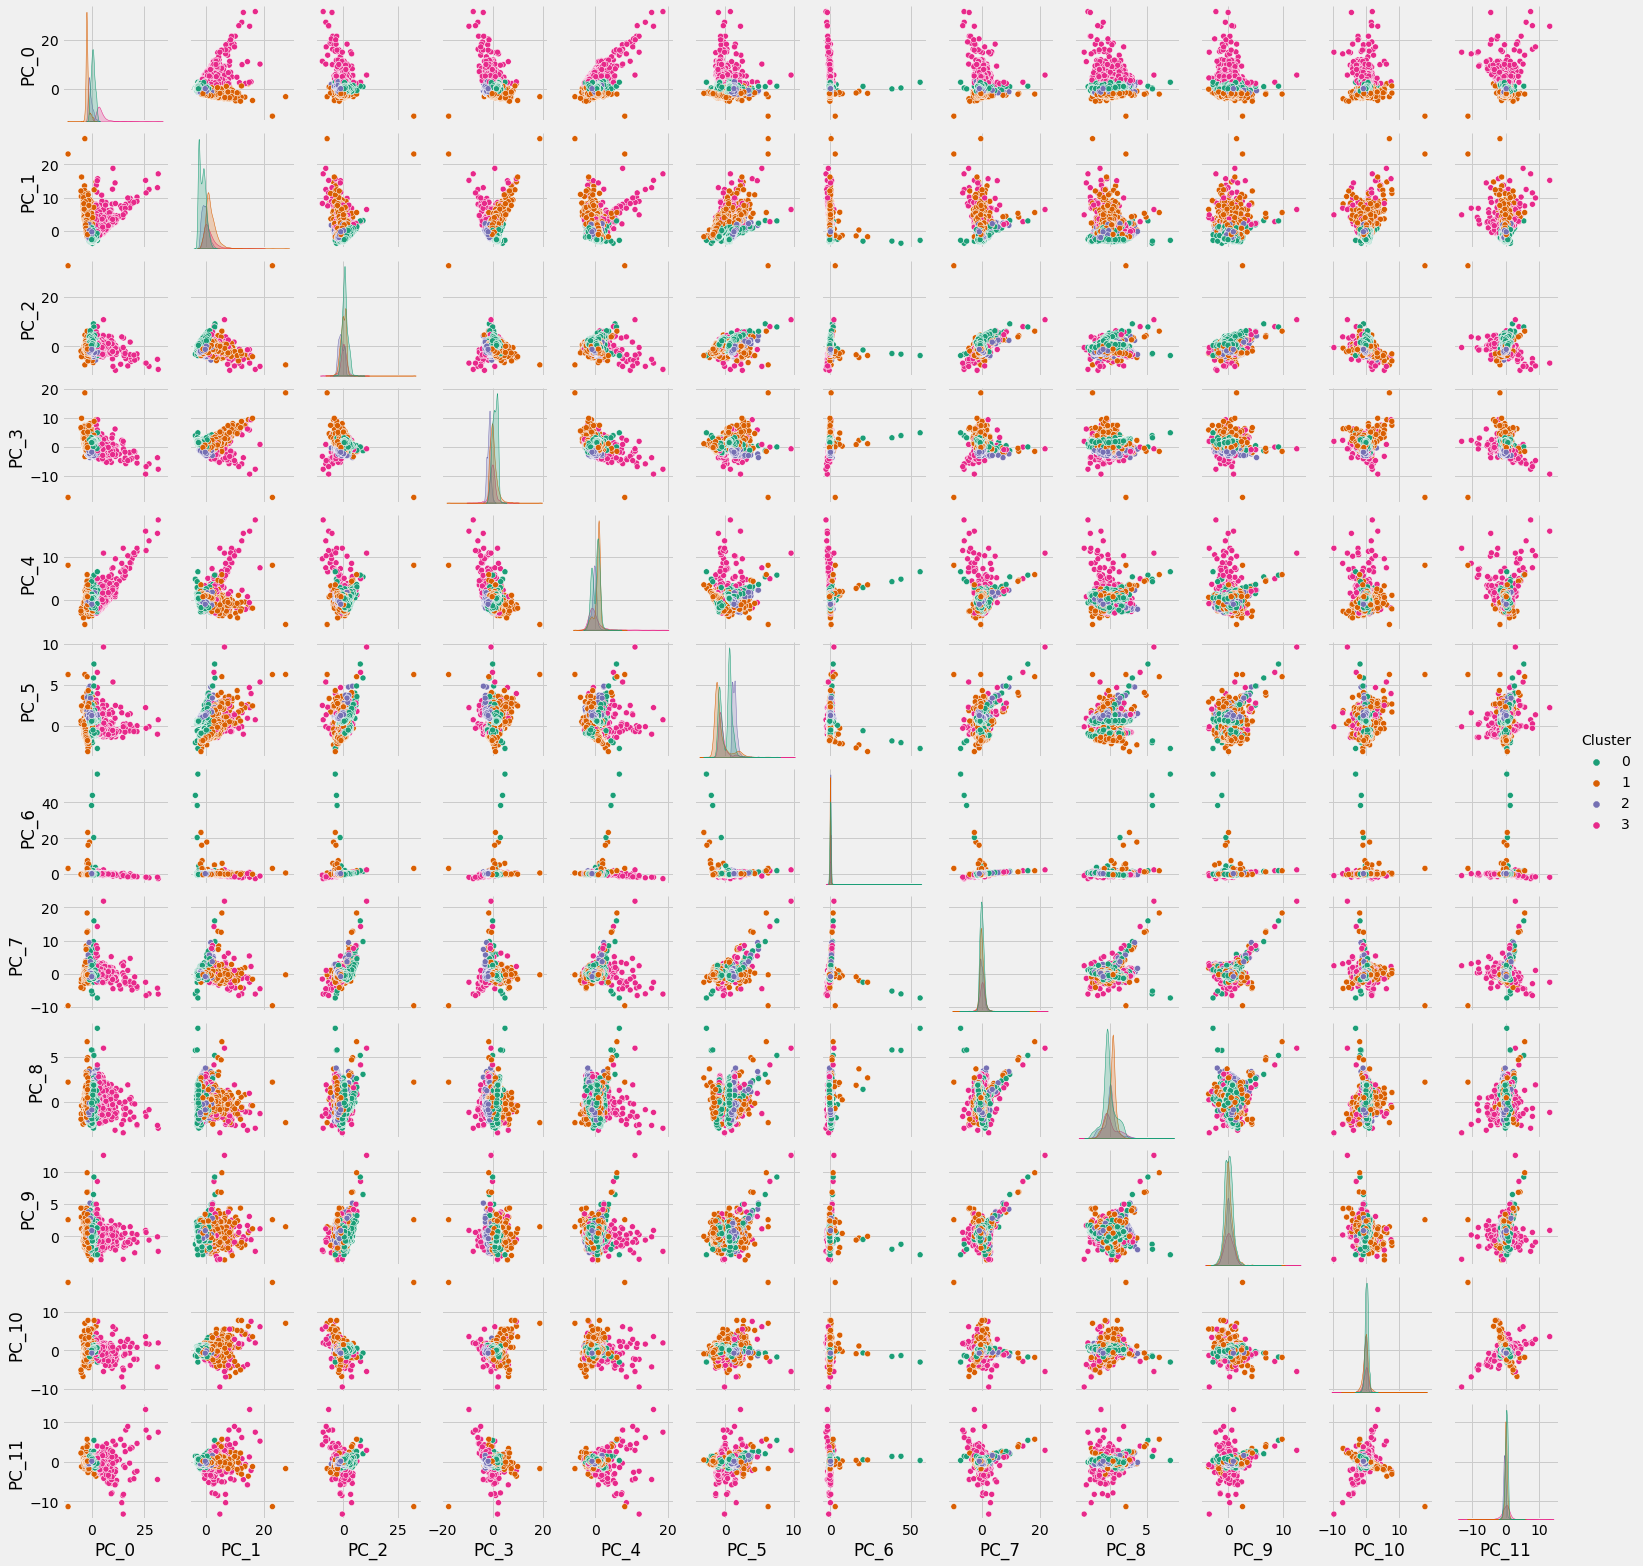

In [56]:
sns.pairplot(df_pair_plot,hue='Cluster', palette= 'Dark2', diag_kind='kde',size=1.85)

In [57]:
# Factor Analysis : variance explained by each component- 
pd.Series(pca_final.explained_variance_ratio_*100,index=['PC_'+ str(i) for i in range(12)])

PC_0     25.371557
PC_1     17.997094
PC_2      9.440644
PC_3      8.822357
PC_4      6.217020
PC_5      5.144669
PC_6      4.158927
PC_7      3.793937
PC_8      3.242197
PC_9      2.863800
PC_10     2.629277
PC_11     2.348980
dtype: float64

##  from the above pairplot and above table , it can be seen that component 0 and 1 are classifying the clusters
It shows that first two components are able to indentify clusters
Now we have done here with principle component now we need to come bring our original data frame and we will merge the cluster with them.

To interprate result we need to use our data frame


In [58]:
credit_pro['cluster']= km_4.labels_

In [59]:
credit_pro =credit_pro.loc[:,~credit_pro.columns.duplicated()]
credit_pro.columns

Index(['PURCHASES', 'CASH_ADVANCE', 'CREDIT_LIMIT', 'PAYMENTS',
       'MINIMUM_PAYMENTS', 'PRC_FULL_PAYMENT', 'LIMIT_USAGE',
       'BALANCE_FREQUENCY', 'ONEOFF_PURCHASES', 'INSTALLMENTS_PURCHASES',
       'PURCHASES_FREQUENCY', 'ONEOFF_PURCHASES_FREQUENCY',
       'PURCHASES_INSTALLMENTS_FREQUENCY', 'CASH_ADVANCE_FREQUENCY',
       'CASH_ADVANCE_TRX', 'PURCHASES_TRX', 'MONTHLY_AVG_PURCHASE',
       'MONTHLY_CASH_ADVANCE', 'PAYMENT_MINPAY', 'both_oneoff_installment',
       'istallment', 'none', 'one_off', 'cluster'],
      dtype='object')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


Text(0.5, 1.0, 'Overview of different clusters')

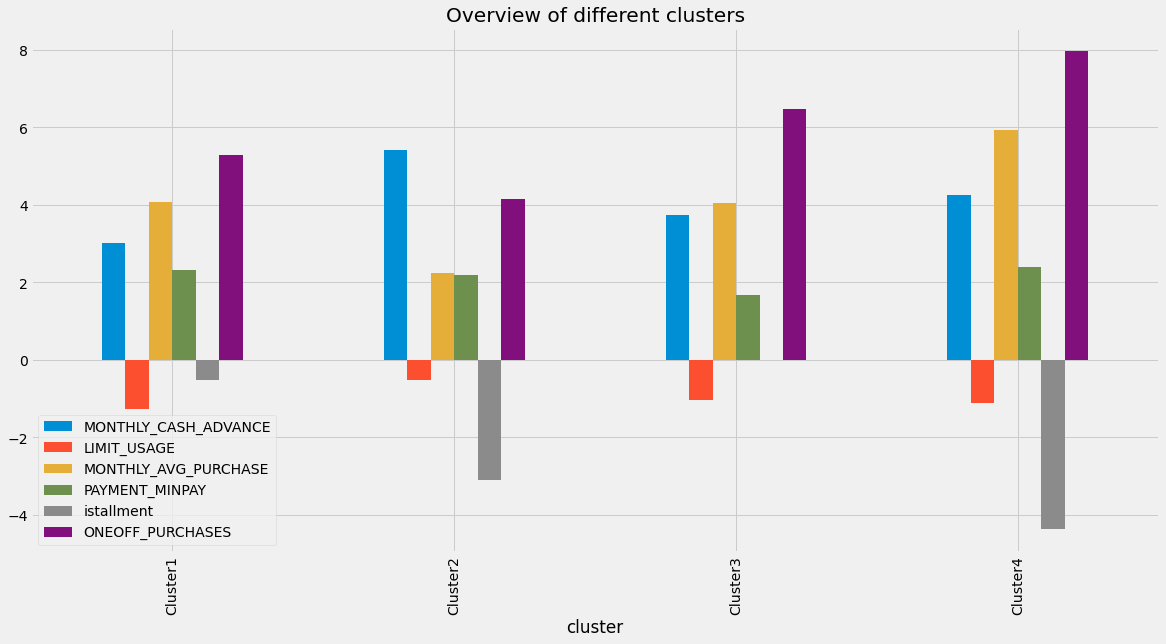

In [60]:
# cols=['PURCHASES','CASH_ADVANCE_TRX','both_oneoff_installment','one_off','istallment','none','cluster']
cols=['MONTHLY_CASH_ADVANCE','LIMIT_USAGE','MONTHLY_AVG_PURCHASE','PAYMENT_MINPAY','istallment','ONEOFF_PURCHASES','cluster']
cluster= credit_pro[cols].groupby('cluster')
np.log(cluster.mean()).plot(kind='bar',figsize=(18,9))
plt.xticks([0,1,2,3],['Cluster1','Cluster2','Cluster3','Cluster4'])
plt.title('Overview of different clusters')



Performance metrics also suggest that K-means with 4 cluster is able to show distinguished characteristics of each cluster.

Insights with 4 Clusters

    cluster 1 is rarely takes it to the credit limit and is paying comparatively higher minimum payment and poor on installments This group is about 23% of the total customer base
    Cluster 2 is the group of customers who have highest monthly cash advance purchases and doing both installment as well as one_off purchases, have comparatively good limit usage. This group is about 31% of the total customer base
    Cluster 3 customers are doing maximum One_Off transactions and least purchase on installment and limit usage is on lower side This group is about 21% of the total customer base

    Cluster 4 customers have maximum one off purchase and are paying dues and are doing maximum Monthly average purchases. This group is about 25% of the total customer base

Marketing Strategy Suggested:
a. Group 2

    They are potential target customers who are paying dues and doing purchases and maintaining comparatively good credit score ) -- we can increase credit limit or can lower down interest rate -- Can be given premium card /loyality cards to increase transactions

b. Group 1

    They have poor credit score and taking only cash on advance. We can target them by providing less interest rate on purchase transaction

c. Group 0

    This group is has minimum paying ratio and using card for just oneoff transactions (may be for utility bills only). This group seems to be risky group.

d. Group 3

    This group is performing best among all as cutomers are maintaining good credit score and paying dues on time. -- Giving rewards point will make them perform more purchases.

